In [22]:
from langchain.document_loaders import DirectoryLoader, PyPDFLoader,TextLoader
from langchain.vectorstores import Pinecone
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone as PC
from pinecone import ServerlessSpec
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
import glob
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import FileSystemBlobLoader
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import PyPDFParser
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import uuid
from openai import OpenAI #Deprecated because i can't use his API(needs money)
from ollama import Client
from more_itertools import chunked  # ou use uma função caseira
import hashlib
import umap.umap_ as umap

import plotly.express as px
import numpy as np

In [23]:
#gerar n versoes da pergunta
#criar novos docs a partir do artigo, categorizados

In [24]:
loader = DirectoryLoader(
    "./rag-projeto/data",
    glob="*.pdf",
    loader_cls=PyPDFLoader
)
txt_loader = DirectoryLoader(
    "./rag-projeto/data",
    glob="*.txt",
    loader_cls=TextLoader
)

In [25]:
def hash_id(text):
    return hashlib.sha256(text.encode('utf-8')).hexdigest()

In [26]:
docs = loader.load() + txt_loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Tamanho máximo de cada pedaço
    chunk_overlap=50 # Sobreposição entre pedaços
)
docs_splitted = text_splitter.split_documents(docs)

texts = [doc.page_content for doc in docs_splitted]
#criar ID para rastrear os vetores
ids = [hash_id(t) for t in texts]
#Apaga todos os vetores mas mantem o index criado
#index.delete(delete_all=True)

In [27]:

os.environ['PINECONE_API_KEY'] = 'pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST'


In [28]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(texts, show_porgress_bar=True)

In [29]:
index_name = "rag"
pc = PC(api_key="pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST")
index = pc.Index(index_name)

In [30]:
# Suponha que cada vetor tenha cerca de 20KB, então 100 vetores ~ 2MB
def batch_upsert(index, vectors, batch_size=100):
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i:i + batch_size]
        index.upsert(vectors=batch)




In [31]:
embedder = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", cache_folder="./ModeltoEmbedding"
)
#texts eh uma lista de strings onde cada string é um documento.Essa função gera os embeddings
embeddings= embedder.embed_documents(texts)
# Associar os embeddings com seus IDs
vectors = [(ids[i] ,embeddings[i]) for i in range(len(embeddings))]

# Inserir os embeddings no Pinecone (upsert)
# index.upsert(vectors=vectors)

# Remove duplicatas por ID antes do upsert
unique_vectors = list({v[0]: v for v in vectors}.values())
# Exemplo de uso
batch_upsert(index, vectors)

# vectorstore = PineconeVectorStore.from_documents(docs_splitted, embedder, index_name=index_name)
index.describe_index_stats()


{'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 8385}},
 'total_vector_count': 8385,
 'vector_type': 'dense'}

In [67]:
query = "Alimentos saudaveis"


#Funçao do pinecone que já realiza a busca
# similar_docs = vectorstore.similarity_search(query, k=5)
#função para pegar o embedding do query
query_embedding = embedder.embed_query(query)

In [68]:

#Resultado do metodo de busca padrao.
# similar_docs
print(index)


In [69]:
#Implementando uma busca personalizada
#Baseando-se na busca de similaridade por cosseno , para mais detalhes: https://pt.wikipedia.org/wiki/Produto_escalar
#Tem esse estudo falando sobre o problema deste método que é interessante: https://www.shaped.ai/blog/cosine-similarity-not-the-silver-bullet-we-thought-it-was
def cosine_similarity(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return np.dot(v1, v2) / (norm1 * norm2)


# Calcular similaridade entre a consulta e todos os documentos
similarities = [cosine_similarity(query_embedding,doc_embedding) for doc_embedding in embeddings]
# Ordenar os índices dos documentos pela similaridade de forma decrescente
sorted_indices = np.argsort(similarities)[::-1]

# Obter os documentos mais semelhantes (top 5)
top_k = 50
top_docs = [texts[i] for i in sorted_indices[:top_k]]
top_similarities = [similarities[i] for i in sorted_indices[:top_k]]
top_embeddings = [embeddings[i] for i in sorted_indices[:top_k]]
# Exibir os resultados
for doc, sim in zip(top_docs, top_similarities):
    print(f"Similaridade: {sim:.4f}")
    print(f"Documento: {doc[:1000]}...")  # Exibir os primeiros 200 caracteres do documento
    print("-" * 50)


Similaridade: 0.7952
Documento: formas de promover a alimentação adequada e saudável....
--------------------------------------------------
Similaridade: 0.7748
Documento: nutricional dos alimentos dos quais derivam.
Alimentos processados inc luem alimentos em conserva, frutas em 
calda, queijos e pães feitos de farinha de trigo, leveduras, água e sal...
--------------------------------------------------
Similaridade: 0.7706
Documento: atenção pelas escolhas alimentares....
--------------------------------------------------
Similaridade: 0.7463
Documento: • grão-de-bico;
• soja;
• amendoim e amêndoas.
Para evitar a falta de cálcio no dia a dia, nada melhor que fazer uma alimentação saudável e com alimentos ricos em nutrientes. A seguir, con�ra
algumas dicas de como colocar em prática esse hábito:
O primeiro passo é optar por uma alimentação balanceada. Isto é, buscar o equilíbrio entre os grupos alimentares e consumir alimentos dos mais...
----------------------------------------------

Dimensão dos embeddings: 384
Todos os embeddings têm dimensões consistentes.


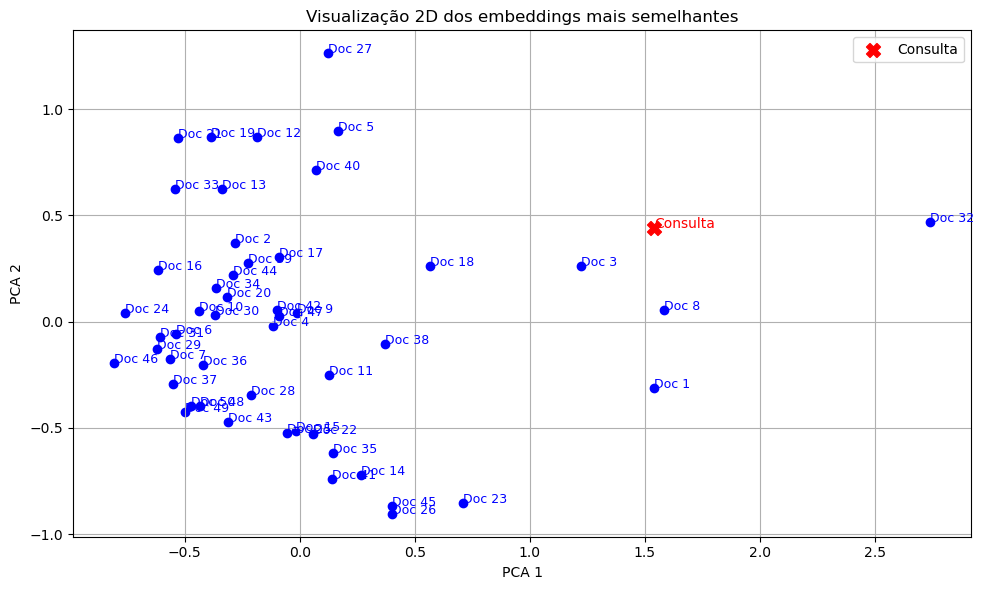

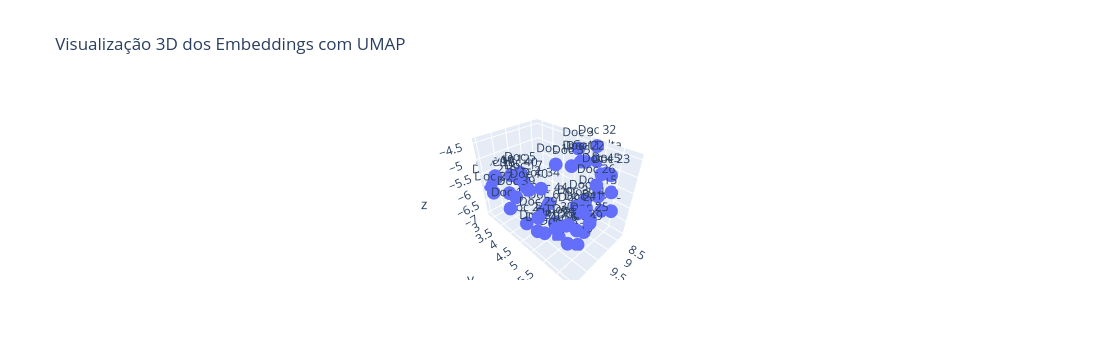

In [70]:
# Verificar a dimensão de um embedding
if embeddings:
    embedding_dim = len(embeddings[0])
    print(f"Dimensão dos embeddings: {embedding_dim}")
else:
    print("Nenhum embedding encontrado.")

# Verificar se todos os embeddings possuem a mesma dimensão
dims = set(len(vec) for vec in embeddings)
if len(dims) > 1:
    print(f"Atenção: Embeddings com diferentes dimensões encontradas: {dims}")
else:
    print("Todos os embeddings têm dimensões consistentes.")

# Redução para 2D com PCA (inclui a query)
top_k = 50
similarities = [cosine_similarity(query_embedding, doc_embedding) for doc_embedding in embeddings]
sorted_indices = np.argsort(similarities)[::-1]
top_embeddings = [embeddings[i] for i in sorted_indices[:top_k]]

points_2d = PCA(n_components=2).fit_transform(np.array(top_embeddings + [query_embedding]))

plt.figure(figsize=(10, 6))
for i in range(top_k):
    plt.scatter(*points_2d[i], color='blue')
    plt.text(points_2d[i][0], points_2d[i][1], f'Doc {i+1}', color='blue', fontsize=9)

plt.scatter(*points_2d[-1], color='red', marker='X', s=100, label='Consulta')
plt.text(points_2d[-1][0], points_2d[-1][1], 'Consulta', color='red', fontsize=10)
plt.title("Visualização 2D dos embeddings mais semelhantes")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Visualização 3D com UMAP (inclui a query)
try:
    reduced_3d = umap.UMAP(n_components=3).fit_transform(np.array(top_embeddings + [query_embedding]))

    fig = px.scatter_3d(
        x=reduced_3d[:, 0],
        y=reduced_3d[:, 1],
        z=reduced_3d[:, 2],
        text=[f'Doc {i+1}' for i in range(top_k)] + ['Consulta'],
        title="Visualização 3D dos Embeddings com UMAP"
    )
    fig.show()
except Exception as e:
    print(f"Erro ao gerar visualização 3D com UMAP: {e}")

In [71]:
#Chamar a IA com o prompt + contexto do RAG
documentos = "\n\n---\n\n".join([texts[i] for i in sorted_indices[:25]])

prompt_final = f"""
Responda à pergunta a seguir com base **exclusiva e estritamente** no conteúdo dos documentos fornecidos. 
Não use conhecimento externo.

[DOCUMENTOS INICIAIS]
{documentos}
[FIM DOS DOCUMENTOS]

Pergunta: {query}

Regras:
- Responda apenas se a informação estiver claramente presente.
- Caso contrário, diga: "A informação solicitada não está presente nos documentos fornecidos."
""".strip()




print(prompt_final)
client = Client()
response = client.chat(
    model='mistral',
    messages=[
       
        {"role": "user", "content": prompt_final},
        
    ]
)

print(response['message']['content'])

Responda à pergunta a seguir com base **exclusiva e estritamente** no conteúdo dos documentos fornecidos. 
Não use conhecimento externo.

[DOCUMENTOS INICIAIS]
formas de promover a alimentação adequada e saudável.

---

nutricional dos alimentos dos quais derivam.
Alimentos processados inc luem alimentos em conserva, frutas em 
calda, queijos e pães feitos de farinha de trigo, leveduras, água e sal

---

atenção pelas escolhas alimentares.

---

• grão-de-bico;
• soja;
• amendoim e amêndoas.
Para evitar a falta de cálcio no dia a dia, nada melhor que fazer uma alimentação saudável e com alimentos ricos em nutrientes. A seguir, con�ra
algumas dicas de como colocar em prática esse hábito:
O primeiro passo é optar por uma alimentação balanceada. Isto é, buscar o equilíbrio entre os grupos alimentares e consumir alimentos dos mais

---

consumo imediato sem utensílios domésticos. 
alimentos ultraprocessados incluem vários tipos de guloseimas, bebidas 
adoçadas com açúcar ou adoçantes artif